In [2]:
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing

# Data Input, EDA & Preprocessing

## Individual Data Input

In [3]:
price_vol = pd.read_csv('../data/Price & Volume BTC.csv')
tweets = pd.read_csv('../data/Tweets.csv')
funding_rates_1600 = pd.read_csv('../data/Funding Rates BTCUSDT 1600.csv')
funding_rates_0800 = pd.read_csv('../data/Funding Rates BTCUSDT 0800.csv')
funding_rates_0000 = pd.read_csv('../data/Funding Rates BTCUSDT 0000.csv')
google = pd.read_csv('../data/Google.csv')
transactions = pd.read_csv('../data/Transactions.csv')
unique_addresses = pd.read_csv('../data/Unique Addresses.csv')
active_addresses = pd.read_csv('../data/Active Addresses.csv')

## Data Compilation

In [4]:
# get daily ave value for twitter attributes
tweets = tweets.groupby(by="Time").mean()
tweets = tweets.reset_index()

df = pd.merge(price_vol, funding_rates_0000, on=['Time'])
df = pd.merge(df, funding_rates_0800, on=['Time'])
df = pd.merge(df, funding_rates_1600, on=['Time'])
df = pd.merge(df, google, on=['Time'])
df = pd.merge(df, active_addresses, on=['Time'])
df = pd.merge(df, unique_addresses, on=['Time'])
df = pd.merge(df, transactions, on=['Time'])
df = pd.merge(df, tweets, how="outer")
df.head()

,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2022-03-03,43896.8,42456.3,44088.0,41832.0,324545814.8,0.01%,0.01%,0.01%,13.84,24.08,1011448,701198.0,268244.0,443.269231,79.576923,0.109327,0.036269,0.063731,0.900000
1,2022-03-02,44428.2,43896.9,45367.5,43332.8,340460526.5,0.00%,0.00%,0.01%,15.61,26.33,1091796,731603.0,288657.0,534.200000,90.366667,0.068437,0.037100,0.068967,0.893967
2,2022-03-01,43174.8,44428.2,44966.0,42796.9,444858241.2,-0.01%,0.01%,0.01%,17.67,29.34,1065354,722863.0,280634.0,353.514286,61.028571,0.006329,0.062714,0.070200,0.867114
3,2022-02-28,37706.7,43179.8,44210.4,37446.5,564121052.5,0.00%,-0.02%,-0.01%,16.20,24.83,981066,702483.0,270918.0,332.333333,61.861111,0.135383,0.033806,0.073306,0.892861
4,2022-02-27,39117.3,37706.7,39864.0,36977.4,388368905.7,0.01%,0.01%,0.00%,12.96,21.07,768705,583361.0,211164.0,128.000000,30.000000,0.106867,0.022667,0.055000,0.922333


In [5]:
print("Type of variables: ", "\n", df.dtypes)

Type of variables:  
 Time                        object
Open                       float64
Close                      float64
High                       float64
Low                        float64
Volume                     float64
Funding Rate 0000           object
Funding Rate 0800           object
Funding Rate 1600           object
Bitcoin_SVI                float64
Cryptocurrency_SVI         float64
No. of Active Addresses      int64
No. of Unique Addresses    float64
Transactions               float64
Favorites                  float64
Retweets                   float64
Compound                   float64
Negative                   float64
Positive                   float64
Neutral                    float64
dtype: object


# Preprocessing

In [6]:
# Select features, the target output is'Close'
feature_pool = ['Time', 'Favorites','Retweets','Compound',\
                'Close',\
                'Volume','Funding Rate 0000','Funding Rate 0800','Funding Rate 1600','Bitcoin_SVI',\
                'Cryptocurrency_SVI','No. of Active Addresses','No. of Unique Addresses','Transactions']

#Note : Close is a feature as well 

output = 'Close'

## Data Type Transformation

In [7]:
# Transform object type of "Funding Rate 0000", "Funding Rate 0800" and " Funding Rate 1600" to numerical type
df['Funding Rate 0000'] = df['Funding Rate 0000'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 0800'] = df['Funding Rate 0800'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 1600'] = df['Funding Rate 1600'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))

df['Month'] = df['Time'].str[:7]
df['Time'] = df['Time'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df['Month'] = df['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df = df.sort_values(by = 'Time', ascending=True)
df.head(10)


,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,...,No. of Active Addresses,No. of Unique Addresses,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral,Month
729,20200304,8761.2,8750.7,8847.1,8655.7,1.221924e+07,0.01,0.01,0.01,8.64,...,857423,625096.0,358745.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
728,20200305,8750.8,9056.9,9153.1,8750.7,1.521845e+07,0.02,0.01,0.02,9.26,...,793221,603996.0,349529.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
727,20200306,9056.2,9134.3,9168.7,8989.1,8.833555e+06,0.02,0.02,0.02,8.95,...,804945,601698.0,338383.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
726,20200307,9133.9,8889.9,9184.9,8789.8,7.525135e+06,0.04,0.04,0.03,7.10,...,682432,526880.0,313312.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
725,20200308,8889.9,8036.5,8889.9,8001.1,1.439716e+07,0.03,0.05,0.05,8.02,...,654911,501571.0,302694.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
724,20200309,8035.0,7931.3,8175.2,7636.3,2.070482e+07,0.04,0.01,0.01,16.05,...,809850,606002.0,348211.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
723,20200310,7931.4,7895.3,8147.1,7736.9,1.365059e+07,0.01,0.01,0.01,12.34,...,807778,601526.0,329698.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
722,20200311,7895.4,7933.2,8000.0,7590.0,1.145017e+07,0.01,0.01,0.01,10.49,...,728889,528053.0,287492.0,NaN,NaN,NaN,NaN,NaN,NaN,202003
721,20200312,7933.2,4802.9,7960.4,4448.6,5.524836e+07,0.02,0.01,0.01,22.83,...,909601,653156.0,349978.0,5.0,2.0,0.0772,0.091,0.1,0.809,202003
720,20200313,4811.8,5576.3,5950.0,3800.0,6.423345e+07,-0.02,-0.02,-0.30,30.86,...,786409,NaN,276798.0,NaN,NaN,NaN,NaN,NaN,NaN,202003


## Handle Missing Data

In [8]:
# Count missing value
print(df.isna().sum())

Time                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Funding Rate 0000            0
Funding Rate 0800            0
Funding Rate 1600            0
Bitcoin_SVI                  0
Cryptocurrency_SVI           0
No. of Active Addresses      0
No. of Unique Addresses      2
Transactions                 0
Favorites                  458
Retweets                   458
Compound                   458
Negative                   458
Positive                   458
Neutral                    458
Month                        0
dtype: int64


### Monthly Sentiment Analysis

In [9]:
tweets.insert(1, "Month", "NaN")

tweets['Month'] = tweets['Time'].str[:7]
tweets['Month'] = tweets['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
tweets.head(10)

,Time,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2020-03-12,202003,5.0,2.0,0.0772,0.091,0.100,0.809
1,2020-03-17,202003,98.0,96.0,0.4019,0.000,0.114,0.886
2,2020-03-20,202003,125.0,95.0,0.4767,0.000,0.146,0.854
3,2020-03-30,202003,3.0,0.0,0.0803,0.061,0.071,0.869
4,2020-03-31,202003,186.0,142.0,0.6597,0.000,0.278,0.722
5,2020-04-01,202004,171.0,120.0,0.5267,0.061,0.184,0.754
6,2020-04-16,202004,419.0,94.0,0.0000,0.000,0.000,1.000
7,2020-04-22,202004,73.0,18.0,0.3182,0.000,0.084,0.916
8,2020-04-30,202004,994.0,153.0,0.0000,0.000,0.000,1.000
9,2020-05-09,202005,35.0,2.0,0.0000,0.000,0.000,1.000


In [10]:
tweets = tweets.groupby(by="Month").mean()
tweets = tweets.reset_index()

In [11]:
tweets.head(10)

,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,202003,83.400000,67.000000,0.339160,0.030400,0.141800,0.828000
1,202004,414.250000,96.250000,0.211225,0.015250,0.067000,0.917500
2,202005,283.285714,49.142857,0.002414,0.027857,0.057429,0.914571
3,202006,232.000000,155.000000,0.401900,0.000000,0.072000,0.928000
4,202007,303.750000,79.000000,0.227450,0.000000,0.065250,0.934750
5,202008,1103.925926,241.740741,0.379407,0.016296,0.146444,0.837407
6,202009,63.500000,17.000000,0.121117,0.000000,0.035000,0.965000
7,202010,300.000000,50.000000,0.405267,0.000000,0.146000,0.854000
8,202011,254.666667,37.833333,0.117625,0.049250,0.123000,0.827750
9,202012,487.428571,56.571429,0.133693,0.058571,0.110143,0.831286


In [12]:
overall_df = pd.DataFrame(columns = ['Time', 'Month', 'Favorites', 'Retweets', 'Compound', \
                                 'Close', 'Volume', 'Funding Rate 0000', 'Funding Rate 0800', \
                                 'Funding Rate 1600', 'Bitcoin_SVI', 'Cryptocurrency_SVI',  'No. of Active Addresses', \
                                 'No. of Unique Addresses', 'Transactions'])

for i, row in df.iterrows():
    if (pd.isna(df.loc[i].at["Favorites"])):
        data = tweets[tweets['Month'] == df.loc[i].at["Month"]]
        new_row = {'Time': df.loc[i].at["Time"], 'Month': df.loc[i].at["Month"], 'Favorites': data.Favorites.values[0], 'Retweets': data.Retweets.values[0], 'Compound': data.Compound.values[0], \
                    
                 'Close': df.loc[i].at["Close"], 'Volume': df.loc[i].at["Volume"], 'Funding Rate 0000': df.loc[i].at["Funding Rate 0000"], \
                   'Funding Rate 0800': df.loc[i].at["Funding Rate 0800"], 'Funding Rate 1600': df.loc[i].at["Funding Rate 1600"], 'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)
    else:
        new_row = {'Time': df.loc[i].at["Time"], 'Month': df.loc[i].at["Month"], 'Favorites': df.loc[i].at["Favorites"], 'Retweets': df.loc[i].at["Retweets"], 'Compound': df.loc[i].at["Compound"], \
                  
                 'Close': df.loc[i].at["Close"],'Volume': df.loc[i].at["Volume"], 'Funding Rate 0000': df.loc[i].at["Funding Rate 0000"], \
                   'Funding Rate 0800': df.loc[i].at["Funding Rate 0800"], 'Funding Rate 1600': df.loc[i].at["Funding Rate 1600"], 'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)


/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3197/415820148.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3197/415820148.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3197/415820148.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3197/415820148.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [13]:
overall_df = overall_df.drop(['Month'], axis = 1)
overall_df.head(10)

,Time,Favorites,Retweets,Compound,Close,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,20200304.0,83.4,67.0,0.33916,8750.7,12219240.24,0.01,0.01,0.01,8.64,4.34,857423.0,625096.0,358745.0
1,20200305.0,83.4,67.0,0.33916,9056.9,15218448.72,0.02,0.01,0.02,9.26,3.76,793221.0,603996.0,349529.0
2,20200306.0,83.4,67.0,0.33916,9134.3,8833554.543,0.02,0.02,0.02,8.95,3.33,804945.0,601698.0,338383.0
3,20200307.0,83.4,67.0,0.33916,8889.9,7525135.261,0.04,0.04,0.03,7.1,3.04,682432.0,526880.0,313312.0
4,20200308.0,83.4,67.0,0.33916,8036.5,14397155.01,0.03,0.05,0.05,8.02,4.34,654911.0,501571.0,302694.0
5,20200309.0,83.4,67.0,0.33916,7931.3,20704818.48,0.04,0.01,0.01,16.05,5.16,809850.0,606002.0,348211.0
6,20200310.0,83.4,67.0,0.33916,7895.3,13650591.37,0.01,0.01,0.01,12.34,4.44,807778.0,601526.0,329698.0
7,20200311.0,83.4,67.0,0.33916,7933.2,11450174.16,0.01,0.01,0.01,10.49,4.23,728889.0,528053.0,287492.0
8,20200312.0,5.0,2.0,0.0772,4802.9,55248355.79,0.02,0.01,0.01,22.83,6.2,909601.0,653156.0,349978.0
9,20200313.0,83.4,67.0,0.33916,5576.3,64233445.37,-0.02,-0.02,-0.3,30.86,6.71,786409.0,NaN,276798.0


Text(0.5, 1.0, 'Price of BTC From 4th March 2020 to 3rd March 2022')

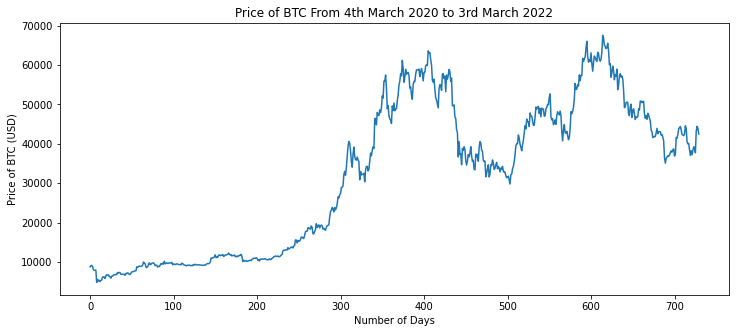

In [27]:
fig = plt.figure(figsize=(12,5))
plt.plot(overall_df['Close'])
plt.xlabel('Number of Days')
plt.ylabel('Price of BTC (USD)')
plt.title("Price of BTC From 4th March 2020 to 3rd March 2022")

# Train-Test Split


In [14]:
from sklearn.model_selection import TimeSeriesSplit
X, y = overall_df, overall_df[output]
tscv = TimeSeriesSplit()
for train_index, val_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", val_index)
  X_train, X_test = X.iloc[train_index], X.iloc[val_index]
  y_train, y_test = y.iloc[train_index], y.iloc[val_index]

print(y_train.sum()/y_train.count(),y_test.sum()/y_test.count())


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124] TEST: [125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 

In [15]:
from sklearn.model_selection import TimeSeriesSplit
X, y = overall_df, overall_df[output]
tscv = TimeSeriesSplit()
for train_index, val_index in tscv.split(X):
  print("TRAIN:", train_index, "TEST:", val_index)
  X_train, X_test = X.iloc[train_index], X.iloc[val_index]
  y_train, y_test = y.iloc[train_index], y.iloc[val_index]

print(y_train.sum()/y_train.count(),y_test.sum()/y_test.count())


# check the consistency of columns with missing value between train set and the whole set
print(df[feature_pool].isnull().any().tolist()==X_train.isnull().any().tolist())
print(df[output].isnull().any().tolist()==y_train.isnull().any().tolist())

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124] TEST: [125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 

### NaN Values

In [16]:
KNN_miss_filling = KNNImputer(n_neighbors=2).fit(X_train)
X_train = pd.DataFrame(KNN_miss_filling.transform(X_train), columns=feature_pool)
X_test = pd.DataFrame(KNN_miss_filling.transform(X_test), columns=feature_pool)

In [17]:
print(X_train.isna().sum())
print(X_test.isna().sum())

Time                       0
Favorites                  0
Retweets                   0
Compound                   0
Close                      0
Volume                     0
Funding Rate 0000          0
Funding Rate 0800          0
Funding Rate 1600          0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
dtype: int64
Time                       0
Favorites                  0
Retweets                   0
Compound                   0
Close                      0
Volume                     0
Funding Rate 0000          0
Funding Rate 0800          0
Funding Rate 1600          0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    0
Transactions               0
dtype: int64


## Preprocessing

In [18]:
# Standardized features:
standardized_features = ['Favorites','Retweets','Compound','Bitcoin_SVI']     
non_standardized_features = list(set(feature_pool)-set(standardized_features))
    
# Get the scaler based on train set
scaler = preprocessing.StandardScaler().fit(X_train[standardized_features])
print('The mean and standard deviation of training set:', scaler.mean_, scaler.scale_)

# Standardize the features of train and test sets by the scaler of training set
X_train_std=pd.DataFrame(scaler.transform(X_train[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
X_train_nstd=pd.DataFrame(X_train[non_standardized_features])

X_test_std=pd.DataFrame(scaler.transform(X_test[standardized_features]))  # return 'numpy.ndarray', not 'DataFrame' or 'Series'
X_test_nstd=pd.DataFrame(X_test[non_standardized_features])

# Rename the columns of X_train_std and X_test_std
X_train_std.columns = X_train_std.columns.map(lambda x: standardized_features[x])
X_test_std.columns = X_test_std.columns.map(lambda x: standardized_features[x])

# Re-combine the normalized and non-normalized data together for both train ans test sets (3 pts)
X_train_std.reset_index(drop=True, inplace=True)
X_train_nstd.reset_index(drop=True, inplace=True)
X_train = pd.concat([X_train_std,X_train_nstd], sort=False,axis=1)
X_test_std.reset_index(drop=True, inplace=True)
X_test_nstd.reset_index(drop=True, inplace=True)
X_test = pd.concat([X_test_std,X_test_nstd], sort=False,axis=1)

# Update the order within feature pool
feature_pool = list(X_train.columns)

The mean and standard deviation of training set: [1.06680030e+03 1.76550006e+02 2.59484422e-01 1.35975862e+01] [1.51170962e+03 2.84742939e+02 2.08351823e-01 1.00053401e+01]


# Identifying Correlations 

<Figure size 1440x576 with 0 Axes>

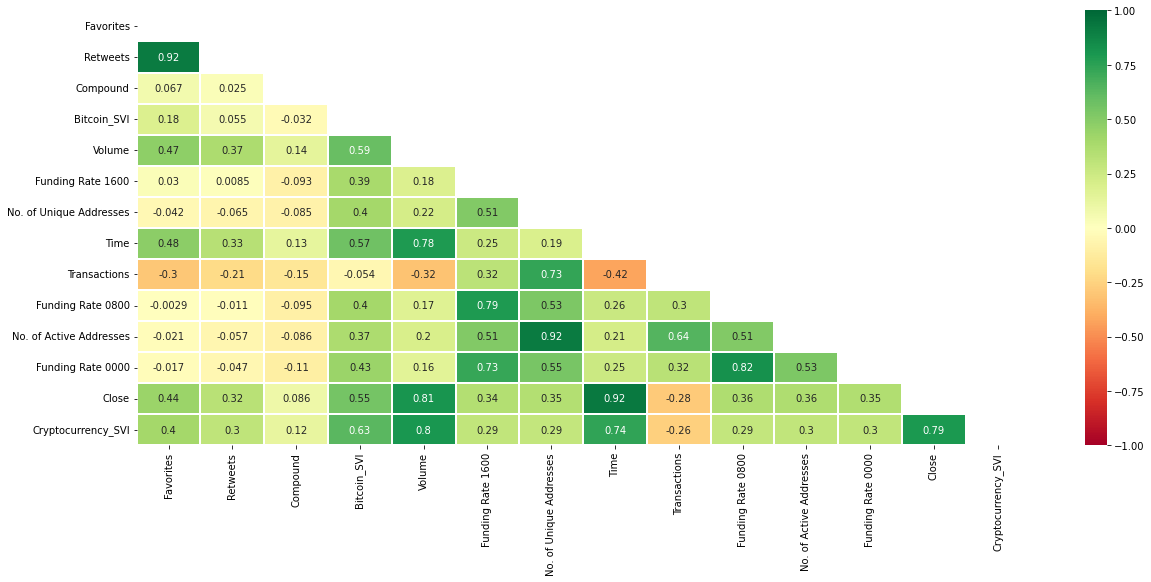

In [19]:
cols = X_train.columns 
corr = X_train[cols].corr()
plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
#returns an array of given shape and type as given array, with zeros
mask = np.zeros_like(corr)

# Return the indices for the upper-triangle of arr and makes it true
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=1.5,annot = True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# Export Data

In [21]:
X_test.to_csv('../data/X_test_scaled.csv', index=False)
X_train.to_csv('../data/X_train_scaled.csv', index=False)
y_train.to_csv('../data/Y_train_scaled.csv', index=False)
y_test.to_csv('../data/Y_test_scaled.csv', index=False)